In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize

import nltk
from nltk.corpus import stopwords

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report 


In [15]:
np.random.seed(42)

In [51]:
# Loading data
def load_data(file_path):
    data = pd.read_csv(file_path, sep=';', names=['text', 'label'])
    return data

train_data = load_data('data/train.txt')
val_data = load_data('data/val.txt')
test_data = load_data('data/test.txt')



In [16]:
text_data = pd.read_csv('data/text.csv', sep = ',', names = ['text', 'label_enc'], header= 1)

In [17]:
text_data.tail()

,text,label_enc
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3
416808,i think that after i had spent some time inves...,5


sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

In [54]:
label_mapping = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5
}

# Apply the manual encoding to the labels in all datasets
train_data['label_enc'] = train_data['label'].map(label_mapping)
val_data['label_enc'] = val_data['label'].map(label_mapping)
test_data['label_enc'] = test_data['label'].map(label_mapping)

In [55]:
train_data = train_data.drop('label', axis=1)
train_data.head()

,text,label_enc
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


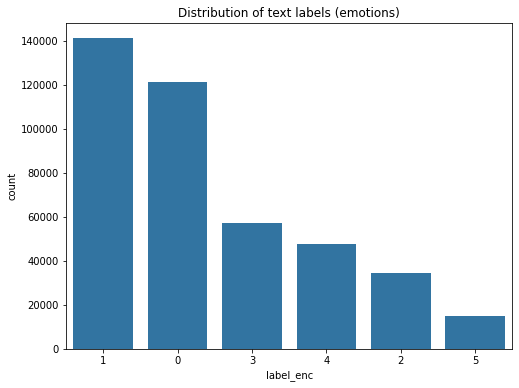

In [56]:
plt.figure(figsize=(8,6))

sns.countplot(x='label_enc', data = text_data, order = text_data['label_enc'].value_counts().index)
plt.title("Distribution of text labels (emotions)")
plt.show()

In [57]:
def resample_train_data(df, big_dataset):
    # using two datasets: df - is the original dataset used in all previous works
                        # big_dataset - similar dataset with the same 5 class emotions just much bigger
    
    anger_df = df[df['label_enc'] == 3]
    joy_df = df[df['label_enc'] == 1]
    sadness_df = df[df['label_enc'] == 0]
    
    fear_df = big_dataset[big_dataset['label_enc'] == 4]
    love_df = big_dataset[big_dataset['label_enc'] == 2]
    surprise_df = big_dataset[big_dataset['label_enc'] == 5]
    
    # Step 2: Randomly select 2000 entries every class
    
    joy_sampled = joy_df.sample(n=2000, random_state=42)
    sadness_sampled = sadness_df.sample(n=2000, random_state=42)
    anger_sampled = anger_df.sample(n=2000, random_state=42)

    #fear showed good results, however it was also oversmapled a little bit
    fear_sampled = fear_df.sample(n=2000, random_state=42)
    
    # love and surprise showed poor results from oversampling in previuos notebook, hence this approach with bigger dataset
    love_sampled = love_df.sample(n=2000, random_state=42)
    surprise_sampled = surprise_df.sample(n=2000, random_state = 42)
   
    
    
    # Step 5: Combine all the balanced samples into a new DataFrame
    balanced_df = pd.concat([anger_sampled, fear_sampled, joy_sampled, sadness_sampled, love_sampled, surprise_sampled])
    
    # Step 6: Shuffle the final balanced dataset to mix the samples
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
  
    return balanced_df  

In [58]:
train_data = resample_train_data(train_data, text_data)

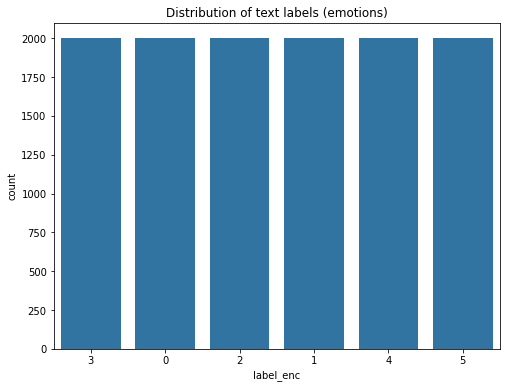

In [59]:
plt.figure(figsize=(8,6))

sns.countplot(x='label_enc', data = train_data, order = train_data['label_enc'].value_counts().index)
plt.title("Distribution of text labels (emotions)")
plt.show()

In [45]:
train_data.head()

,text,label_enc
0,i suppose i m feeling a little sarcastic about...,3
1,i love to sew cook and also dabble in mixed me...,0
2,i didn t want to tell him because arun has the...,3
3,i feel kind of affectionate towards him,2
4,i was feeling grumpy not women problems grumpy...,3


In [60]:
train_data.shape

(12000, 2)

In [62]:
train_data.to_csv('train_resampled.csv', index=False)

In [64]:
# Tokenise, remove stopwords and lowercase
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)


train_data['processed_text'] = train_data['text'].apply(preprocess_text)
val_data['processed_text'] = val_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

In [67]:
y_train = train_data['label_enc']
y_val = val_data['label_enc']
y_test = test_data['label_enc']

In [65]:
# Using TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features for larger vocab
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

In [68]:
#checking TEST accuracy 
# trying base models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel='linear')
}

# Train and evaluate models 
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_test_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_test_pred) #Test Accuracy
    print(f'{model_name} Test Accuracy: {acc}')

Logistic Regression Test Accuracy: 0.876
Random Forest Test Accuracy: 0.866
SVM Test Accuracy: 0.873


In [71]:

# create CatBoost Pool
train_pool = Pool(data=X_train_tfidf, label=y_train)
val_pool = Pool(data=X_val_tfidf, label=y_val)
test_pool = Pool(data=X_test_tfidf, label=y_test)

# initialize and train the CatBoost model
catboost_model = CatBoostClassifier(
    depth=8,             
    iterations=1000,     
    learning_rate=0.5,   
    verbose=1   
)

catboost_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

    

0:	learn: 1.6406190	test: 1.7145928	best: 1.7145928 (0)	total: 904ms	remaining: 15m 2s
1:	learn: 1.5286256	test: 1.6583430	best: 1.6583430 (1)	total: 1.68s	remaining: 13m 59s
2:	learn: 1.4707187	test: 1.6130769	best: 1.6130769 (2)	total: 2.41s	remaining: 13m 21s
3:	learn: 1.4288013	test: 1.5748278	best: 1.5748278 (3)	total: 3.03s	remaining: 12m 33s
4:	learn: 1.3788727	test: 1.5313176	best: 1.5313176 (4)	total: 3.65s	remaining: 12m 7s
5:	learn: 1.3238427	test: 1.4853981	best: 1.4853981 (5)	total: 4.29s	remaining: 11m 51s
6:	learn: 1.2836025	test: 1.4586282	best: 1.4586282 (6)	total: 4.96s	remaining: 11m 43s
7:	learn: 1.2367229	test: 1.4209805	best: 1.4209805 (7)	total: 5.61s	remaining: 11m 35s
8:	learn: 1.2066472	test: 1.3938108	best: 1.3938108 (8)	total: 6.32s	remaining: 11m 35s
9:	learn: 1.1721306	test: 1.3647022	best: 1.3647022 (9)	total: 7.02s	remaining: 11m 34s
10:	learn: 1.1345289	test: 1.3331857	best: 1.3331857 (10)	total: 7.62s	remaining: 11m 25s
11:	learn: 1.0989200	test: 1.303

In [73]:
# make predictions
y_val_pred = catboost_model.predict(val_pool)
y_test_pred = catboost_model.predict(test_pool)

# extract accuracy score
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)



Validation Accuracy: 0.8885
Test Accuracy: 0.8825


In [76]:
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


# Define the original class labels (in the same order as they were encoded)
target_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# classification report
print("\nClassification Report (Validation):")
print(classification_report(y_test, y_test_pred, target_names=target_names))

Validation Accuracy: 0.8885
Test Accuracy: 0.8825

Classification Report (Validation):
              precision    recall  f1-score   support

     sadness       0.97      0.89      0.92       581
         joy       0.96      0.85      0.91       695
        love       0.67      0.95      0.79       159
       anger       0.86      0.94      0.90       275
        fear       0.86      0.82      0.84       224
    surprise       0.56      0.97      0.71        66

    accuracy                           0.88      2000
   macro avg       0.81      0.90      0.84      2000
weighted avg       0.90      0.88      0.89      2000



##### It is unexpected that with resampled surprice and love emotions are still lacking behind based on precision.

### Lets try to use raw data without any resampling

#### Getting the data again

In [79]:
def load_data(file_path):
    data = pd.read_csv(file_path, sep=';', names=['text', 'label'])
    return data

train_data = load_data('data/train.txt')
val_data = load_data('data/val.txt')
test_data = load_data('data/test.txt')

#### Apply preprocessing

In [82]:

train_data['processed_text'] = train_data['text'].apply(preprocess_text)
val_data['processed_text'] = val_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

le = LabelEncoder()
train_data['label_enc'] = le.fit_transform(train_data['label'])
val_data['label_enc'] = le.transform(val_data['label'])
test_data['label_enc'] = le.transform(test_data['label'])

y_train = train_data['label']
y_val = val_data['label']
y_test = test_data['label']

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features for larger vocab
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

#### CatBoost with GridSearch best parameters

In [84]:

# create CatBoost Pool
train_pool = Pool(data=X_train_tfidf, label=y_train)
val_pool = Pool(data=X_val_tfidf, label=y_val)
test_pool = Pool(data=X_test_tfidf, label=y_test)

# initialize and train the CatBoost model
catboost_model = CatBoostClassifier(
    depth=8,             
    iterations=1000,     
    learning_rate=0.5,   
    verbose=1   
)

catboost_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)


0:	learn: 1.6131999	test: 1.6149035	best: 1.6149035 (0)	total: 1s	remaining: 16m 44s
1:	learn: 1.5322703	test: 1.5339429	best: 1.5339429 (1)	total: 2.06s	remaining: 17m 9s
2:	learn: 1.4814554	test: 1.4780198	best: 1.4780198 (2)	total: 3.01s	remaining: 16m 40s
3:	learn: 1.4415894	test: 1.4283078	best: 1.4283078 (3)	total: 3.96s	remaining: 16m 26s
4:	learn: 1.3936419	test: 1.3847063	best: 1.3847063 (4)	total: 4.84s	remaining: 16m 4s
5:	learn: 1.3489849	test: 1.3436301	best: 1.3436301 (5)	total: 5.75s	remaining: 15m 51s
6:	learn: 1.3054949	test: 1.2951054	best: 1.2951054 (6)	total: 6.68s	remaining: 15m 47s
7:	learn: 1.2712866	test: 1.2581391	best: 1.2581391 (7)	total: 7.62s	remaining: 15m 45s
8:	learn: 1.2491564	test: 1.2408974	best: 1.2408974 (8)	total: 8.54s	remaining: 15m 40s
9:	learn: 1.2192504	test: 1.2123103	best: 1.2123103 (9)	total: 10.1s	remaining: 16m 44s
10:	learn: 1.1963890	test: 1.1948091	best: 1.1948091 (10)	total: 12.4s	remaining: 18m 33s
11:	learn: 1.1677759	test: 1.163969

#### Make predictions

In [86]:
# make predictions
y_val_pred = catboost_model.predict(val_pool)
y_test_pred = catboost_model.predict(test_pool)

# extract accuracy score
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


#### Results

In [88]:
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


# original class labels (in the same order as they were encoded)
target_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# classification report
print("\nClassification Report (Validation):")
print(classification_report(y_test, y_test_pred, target_names=target_names))

Validation Accuracy: 0.8960
Test Accuracy: 0.8975

Classification Report (Validation):
              precision    recall  f1-score   support

     sadness       0.90      0.89      0.90       275
         joy       0.86      0.88      0.87       224
        love       0.92      0.92      0.92       695
       anger       0.77      0.77      0.77       159
        fear       0.95      0.93      0.94       581
    surprise       0.69      0.70      0.69        66

    accuracy                           0.90      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.90      0.90      0.90      2000



In [90]:
# import joblib

# joblib.dump(model, 'model_catboost_tuned.pkl')


['model_catboost_tuned.pkl']